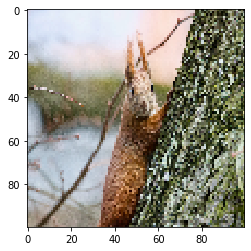

In [1]:
from PIL import Image
from PIL import ImageColor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = np.array(Image.open('image2.png'))
h, w, c = img.shape
plt.imshow(img)

img_array = img.reshape(-1,3) # (10000,3)


img_coord = np.zeros([h*w, 2], dtype='uint8')

for i in range(h*w):
    img_coord[i,1] = i%h
for i in range(h*w):
    img_coord[i,0] = i //h

## Initialization (centers & clusters)

In [2]:
def Initialization(data, k, method):
    num, feature = data.shape
    cluster = np.zeros([k,feature]) # (k,3)
    
    classification = np.random.randint(k, size=num)
    if method=='random_pick':
        idx = np.random.randint(low=0, high=num, size=k)
        cluster=data[idx,:]
        
    elif method == 'kmean++':
        idx_first_pts = np.random.randint(low=0, high=num)
        cluster[0]=data[idx_first_pts]
        for i in range(1,k):
            D = np.zeros([num, i])
            for j in range(i):
                for k in range(num):
                    D[k,j] += np.sum(np.sqrt((data[k]-cluster[j])**2))
                    
            D_min = np.min(D, axis=1) # (10000,) closest distance of point(k) between each cluster
            sum_value = np.sum(D_min)*np.random.rand() # random value * closest distance
            for l in range(num):
                sum_value -= D_min[l]
                if sum_value <= 0: # minus until sum value less than or equal to zero
                    cluster[i] = data[l]
                    break
    else:
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        for i in range(feature):
            cluster[:,i] = np.random.normal(mean[i], std[i], size=k)

        
    return cluster, classification

## Kernel
For  both kernel  k-means  and  spectral  clustering,  please  use  the  new  kernel defined below to compute the Gram matrix.
$\mathrm{k}\left(x, x^{\prime}\right)=e^{-\gamma_{s}\left\|S(x)-S\left(x^{\prime}\right)\right\|^{2}} \times e^{-\gamma_{c}\left\|C(x)-C\left(x^{\prime}\right)\right\|^{2}}$

In [3]:
from scipy.spatial.distance import pdist, squareform

gamma_c = 1/(255*255)
gamma_s = 1/(100*100)

def kernel(color, coord):
    
    spatial_K = np.exp(-gamma_s * squareform(pdist(coord, 'sqeuclidean')))
    color_K = np.exp(-gamma_c * squareform(pdist(color, 'sqeuclidean')))

    return spatial_K * color_K

## Unnormalized Laplacian
$L=D-W$
* Compute the unnormalized Laplacian $L$
* Compute the first $k$ generalized eigenvectors $u_{1}, \ldots, u_{k}$ of the generalized eigenproblem $L u=\lambda D u$
* Let $U \in \mathbb{R}^{n \times k}$ be the matrix containing the vectors $u_{1}, \ldots, u_{k}$ as columns.
* For $i=1, \ldots, n,$ let $y_{i} \in \mathbb{R}^{k}$ be the vector corresponding to the $i$ -th row of $U$
* Cluster the points $\left(y_{i}\right)_{i=1, \ldots, n}$ in $\mathbb{R}^{k}$ with the $k$ -means algorithm into clusters $C_{1}, \ldots, C_{k}$
* Output: Clusters $A_{1}, \ldots, A_{k}$ with $A_{i}=\left\{j | y_{j} \in C_{i}\right\}$

In [4]:
W = kernel(img_array, img_coord) # Similarity matrix
D = np.diag(np.sum(W,axis=1)) # Degree matrix (same row col summation)
L = D - W # Laplacian
L # (10000,10000)

array([[ 4.11994801e+03, -9.98947075e-01, -9.95412171e-01, ...,
        -8.75557937e-02, -3.05366534e-02, -7.51213408e-02],
       [-9.98947075e-01,  4.08442599e+03, -9.98747383e-01, ...,
        -8.57211420e-02, -2.90068469e-02, -7.31862025e-02],
       [-9.95412171e-01, -9.98747383e-01,  4.03436484e+03, ...,
        -8.33999881e-02, -2.73014429e-02, -7.07504008e-02],
       ...,
       [-8.75557937e-02, -8.57211420e-02, -8.33999881e-02, ...,
         4.64853421e+03, -7.56231329e-01, -9.53576414e-01],
       [-3.05366534e-02, -2.90068469e-02, -2.73014429e-02, ...,
        -7.56231329e-01,  3.57547187e+03, -7.65557361e-01],
       [-7.51213408e-02, -7.31862025e-02, -7.07504008e-02, ...,
        -9.53576414e-01, -7.65557361e-01,  4.44488571e+03]])

In [5]:
eigenvalue_unnorm, eigenvector_unnorm = np.linalg.eig(L)

In [6]:
def choose_eigenvector(value, vector, k):

    # eigenvalue = 0 represents a connected component
    idx = np.argsort(value) 

    # col->eigenvector row -> coordinate
    # choose top k points
    # ignore the smallest eigenvalue (eigenvalue=0, eigenvectors are the same)
    U = vector[:,idx[1:k+1]]

    return U.real.astype(np.float32)

In [7]:
def E_step(data, mean, k):
    new_classification = np.zeros(data.shape[0], dtype='int')

    for idx in range(data.shape[0]):
        distance = np.zeros(k)
        distance = np.sum((data[idx,:]-mean)**2, axis=1) # Distance between each point and cluster

        new_classification[idx] = np.argmin(distance)

    return new_classification

def M_step(data, mean, classification, k):
    # Find the mean of all clusters
    new_mean = np.zeros_like(mean, dtype='float')
    for cluster in range(k):
        new_mean[cluster] = np.sum(data[classification==cluster],axis=0)
        count = len(data[classification==cluster])
        if count == 0:
            count += 1
            
        new_mean[cluster] = new_mean[cluster] / count

    return new_mean
           
    
def visualize(img_array, classification, color, iteration, initial, file_name):
    h_w, c = img_array.shape
    h = w = int(h_w**0.5)
    img = np.zeros([h,w,3])
    for i in range(h):
        for j in range(w):
            img[i,j] = color[classification[i*h + j]]
            
    plt.axis('off')
    plt.imshow(img.astype('uint8'))
    plt.show()
    result = Image.fromarray((img).astype('uint8'))
    # result.save(f'{file_name}_{initial}_{iteration:02}.png')

## K-means with eigenvalue U input
### E-step
$r_{n k}=\left\{\begin{array}{l}
1 \quad \text { if } k=\underset{k}{\operatorname{argmin}}\left\|x_{n}-\mu_{k}\right\| \\
0 \quad \text { otherwise }
\end{array}\right.$

### M-step
$\frac{\partial J}{\partial \mu_{k}}=0 \Rightarrow 2 \sum_{n=1}^{N} r_{n k}\left(x_{n}-\mu_{k}\right)=0 \Rightarrow \mu_{k}=\frac{\sum_{n} r_{n k} x_{n}}{\sum_{n} r_{n k}}$

In [8]:
color_select = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
color_rgb = []
for c in color_select:
    color_rgb.append(ImageColor.getrgb(c))

def k_means(data, k, initial, file_name, max_iteration=20, color_rgb=color_rgb):
    
    # mean comes from U (k,k) are n points with n coordinates
    mean, classification = Initialization(data, k,'kmean++')
    iteration = 0
    prev_error = -np.inf
    print(f'Mean:\n{mean}')

    while(iteration < max_iteration):
        print(f'Iteration = {iteration}')
        print(f'Current mean:\n{mean}')
        prev_classification = classification
        visualize(data, classification, color_rgb, iteration, initial, file_name)
        classification = E_step(data, mean, k)
        error = np.sum(np.absolute(classification - prev_classification))
        print(f'error = {error}')
#         if error == prev_error:
#             break
        prev_error = error
        mean = M_step(data, mean, classification, k)
        iteration += 1
    return classification

#draw_eigenspace(filename, storename, iteration, classification, initial_method, data)

Mean:
[[-1.15e-02 -7.89e-04  1.30e-04]
 [ 3.03e-03  2.42e-04 -4.23e-05]
 [-4.64e-03 -2.43e-04  4.23e-05]]
Iteration = 0
Current mean:
[[-1.15e-02 -7.89e-04  1.30e-04]
 [ 3.03e-03  2.42e-04 -4.23e-05]
 [-4.64e-03 -2.43e-04  4.23e-05]]


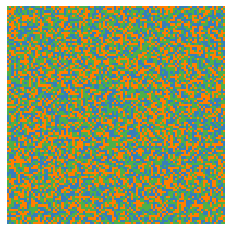

error = 8305
Iteration = 1
Current mean:
[[-1.33e-02 -8.47e-04  1.49e-04]
 [ 7.11e-03  4.08e-04 -7.30e-05]
 [-4.25e-03 -1.82e-04  3.44e-05]]


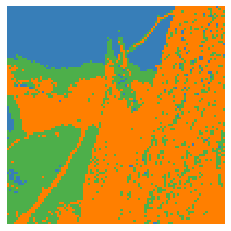

error = 1371
Iteration = 2
Current mean:
[[-1.36e-02 -8.73e-04  1.53e-04]
 [ 8.91e-03  4.90e-04 -8.80e-05]
 [-3.11e-03 -1.13e-04  2.18e-05]]


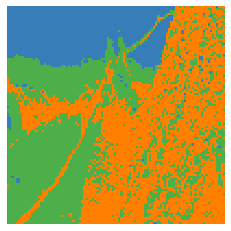

error = 837
Iteration = 3
Current mean:
[[-1.34e-02 -8.57e-04  1.51e-04]
 [ 1.02e-02  5.44e-04 -9.82e-05]
 [-2.23e-03 -5.83e-05  1.21e-05]]


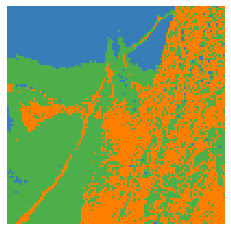

error = 674
Iteration = 4
Current mean:
[[-1.31e-02 -8.36e-04  1.47e-04]
 [ 1.13e-02  5.83e-04 -1.06e-04]
 [-1.57e-03 -1.71e-05  4.86e-06]]


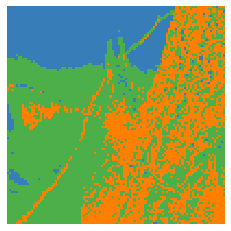

error = 554
Iteration = 5
Current mean:
[[-1.28e-02 -8.11e-04  1.43e-04]
 [ 1.20e-02  6.10e-04 -1.11e-04]
 [-1.07e-03  1.44e-05 -6.95e-07]]


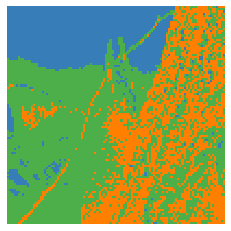

error = 542
Iteration = 6
Current mean:
[[-1.24e-02 -7.81e-04  1.38e-04]
 [ 1.27e-02  6.29e-04 -1.15e-04]
 [-6.10e-04  4.25e-05 -5.69e-06]]


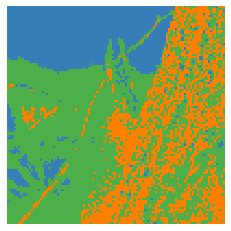

error = 527
Iteration = 7
Current mean:
[[-1.20e-02 -7.49e-04  1.32e-04]
 [ 1.32e-02  6.44e-04 -1.18e-04]
 [-1.91e-04  6.84e-05 -1.03e-05]]


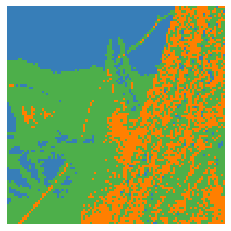

error = 498
Iteration = 8
Current mean:
[[-1.16e-02 -7.20e-04  1.27e-04]
 [ 1.36e-02  6.55e-04 -1.20e-04]
 [ 1.96e-04  9.25e-05 -1.45e-05]]


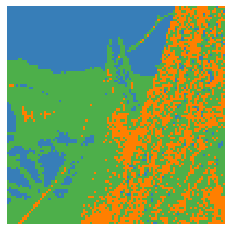

error = 416
Iteration = 9
Current mean:
[[-1.13e-02 -6.96e-04  1.23e-04]
 [ 1.39e-02  6.63e-04 -1.22e-04]
 [ 5.14e-04  1.12e-04 -1.80e-05]]


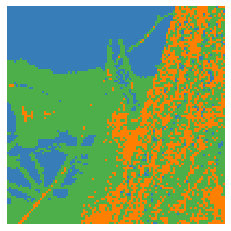

error = 352
Iteration = 10
Current mean:
[[-1.10e-02 -6.76e-04  1.20e-04]
 [ 1.42e-02  6.70e-04 -1.23e-04]
 [ 7.85e-04  1.29e-04 -2.10e-05]]


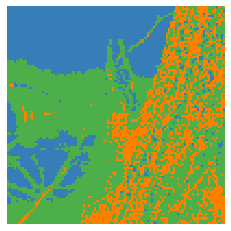

error = 312
Iteration = 11
Current mean:
[[-1.08e-02 -6.60e-04  1.17e-04]
 [ 1.45e-02  6.76e-04 -1.25e-04]
 [ 1.03e-03  1.44e-04 -2.36e-05]]


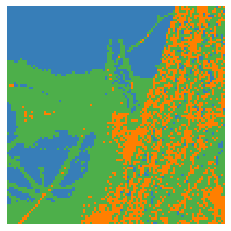

error = 243
Iteration = 12
Current mean:
[[-1.06e-02 -6.47e-04  1.15e-04]
 [ 1.47e-02  6.80e-04 -1.26e-04]
 [ 1.22e-03  1.55e-04 -2.56e-05]]


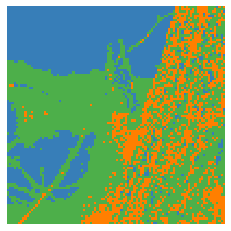

error = 207
Iteration = 13
Current mean:
[[-1.05e-02 -6.38e-04  1.13e-04]
 [ 1.50e-02  6.84e-04 -1.27e-04]
 [ 1.40e-03  1.66e-04 -2.75e-05]]


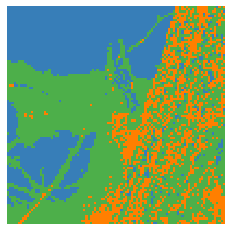

error = 162
Iteration = 14
Current mean:
[[-1.04e-02 -6.32e-04  1.12e-04]
 [ 1.52e-02  6.88e-04 -1.28e-04]
 [ 1.54e-03  1.75e-04 -2.91e-05]]


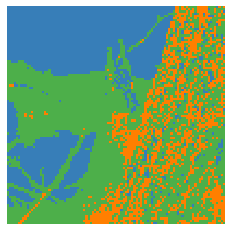

error = 96
Iteration = 15
Current mean:
[[-1.04e-02 -6.27e-04  1.11e-04]
 [ 1.53e-02  6.90e-04 -1.28e-04]
 [ 1.62e-03  1.80e-04 -3.00e-05]]


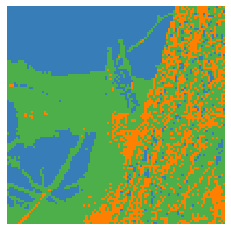

error = 60
Iteration = 16
Current mean:
[[-1.03e-02 -6.25e-04  1.11e-04]
 [ 1.54e-02  6.91e-04 -1.29e-04]
 [ 1.67e-03  1.83e-04 -3.05e-05]]


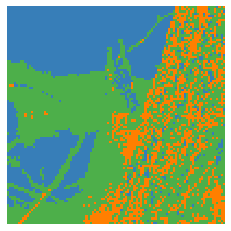

error = 45
Iteration = 17
Current mean:
[[-1.03e-02 -6.23e-04  1.11e-04]
 [ 1.55e-02  6.93e-04 -1.29e-04]
 [ 1.72e-03  1.86e-04 -3.10e-05]]


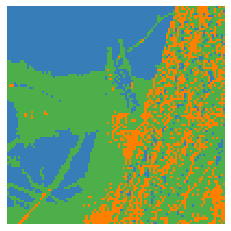

error = 31
Iteration = 18
Current mean:
[[-1.03e-02 -6.22e-04  1.11e-04]
 [ 1.56e-02  6.94e-04 -1.29e-04]
 [ 1.75e-03  1.88e-04 -3.13e-05]]


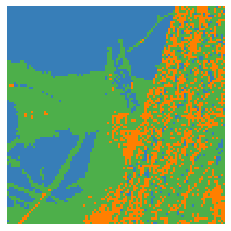

error = 15
Iteration = 19
Current mean:
[[-1.03e-02 -6.21e-04  1.10e-04]
 [ 1.56e-02  6.94e-04 -1.29e-04]
 [ 1.76e-03  1.88e-04 -3.14e-05]]


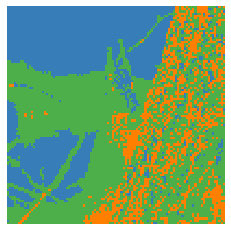

error = 6


In [9]:
np.set_printoptions(precision=2)
k = 3
U = choose_eigenvector(np.real(eigenvalue_unnorm), np.real(eigenvector_unnorm), k)
new_classification = k_means(U, k, initial='kmean++', file_name='rabbit')

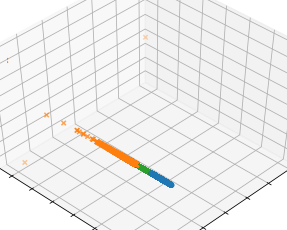

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_eigenvector(x, y, z, C):


    fig = plt.figure(1, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134) 
    markers = ['o','x','*']
    for marker, i in zip(markers, np.arange(3)):
        ax.scatter(x[C==i],y[C==i],z[C==i], marker=marker)


    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    
    ax.dist = 7
    
plot_eigenvector(U[:,0], U[:,1], U[:,2], new_classification)

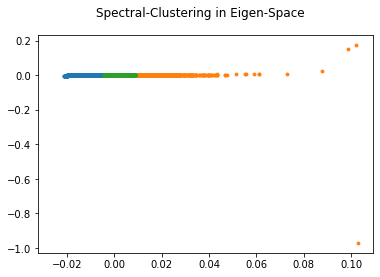

In [11]:
def draw_eigenspace(classification, data, K):
    plt.clf()
    title = "Spectral-Clustering in Eigen-Space"
    plt.suptitle(title)
    for cluster in range(K):
        plt.scatter(data[classification==cluster][:,0], data[classification==cluster][:,1], s=8)
                
                
draw_eigenspace(new_classification, U, k)

## Normalized Laplacian
$L_{\text {sym }} = D^{-1 / 2} L D^{-1 / 2}$
* Construct a similarity graph by one of the ways described in Section 2. Let $W$ be its weighted adjacency matrix.
* Compute the normalized Laplacian $L_{\text {sym }} = D^{-1 / 2} L D^{-1 / 2}$
* Compute the first $k$ eigenvectors $u_{1}, \ldots, u_{k}$ of $L_{\mathrm{sym}}$
* Let $U \in \mathbb{R}^{n \times k}$ be the matrix containing the vectors $u_{1}, \ldots, u_{k}$ as columns.
* Form the matrix $T \in \mathbb{R}^{n \times k}$ from $U$ by normalizing the rows to norm 1 that is set $t_{i j}=u_{i j} /\left(\sum_{k} u_{i k}^{2}\right)^{1 / 2}$
* For $i=1, \ldots, n,$ let $y_{i} \in \mathbb{R}^{k}$ be the vector corresponding to the $i$ -th row of $T$ Cluster the points $\left(y_{i}\right)_{i=1, \ldots, n}$ with the $k$ -means algorithm into clusters $C_{1}, \ldots, C_{k}$ Output: Clusters $A_{1}, \ldots, A_{k}$ with $A_{i}=\left\{j | y_{j} \in C_{i}\right\}$

In [12]:
W = kernel(img_array, img_coord) # Similarity matrix
D = np.diag(np.sum(W, axis=1)) # Degree matrix (same row col summation)
L = D - W # Laplacian

D_inv_sqrt = np.zeros_like(D) # (10000,10000)

for i in range(len(D)):
    D_inv_sqrt[i,i] = 1/np.sqrt(D[i,i])
L_sym = D_inv_sqrt @ L @ D_inv_sqrt

In [13]:
eigenvalue_norm, eigenvector_norm = np.linalg.eig(L_sym)

Mean:
[[-0.52 -0.16 -0.11  0.83]
 [ 0.23  0.59 -0.64  0.44]
 [ 0.48  0.07 -0.19 -0.85]
 [-0.07  0.99  0.14  0.04]]
Iteration = 0
Current mean:
[[-0.52 -0.16 -0.11  0.83]
 [ 0.23  0.59 -0.64  0.44]
 [ 0.48  0.07 -0.19 -0.85]
 [-0.07  0.99  0.14  0.04]]


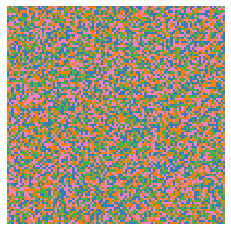

error = 12806
Iteration = 1
Current mean:
[[-0.26 -0.42  0.11  0.25]
 [ 0.22  0.28 -0.53  0.53]
 [ 0.29 -0.17 -0.14 -0.46]
 [-0.17  0.64  0.35 -0.  ]]


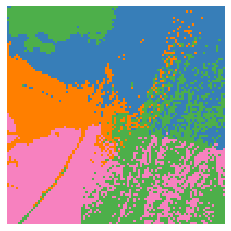

error = 1589
Iteration = 2
Current mean:
[[-0.32 -0.46  0.13  0.11]
 [ 0.18  0.25 -0.49  0.58]
 [ 0.43 -0.15 -0.17 -0.46]
 [-0.15  0.64  0.35 -0.02]]


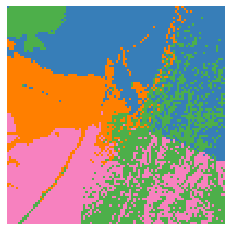

error = 1218
Iteration = 3
Current mean:
[[-0.4  -0.44  0.07  0.01]
 [ 0.17  0.19 -0.46  0.61]
 [ 0.63 -0.13 -0.12 -0.43]
 [-0.15  0.63  0.36 -0.02]]


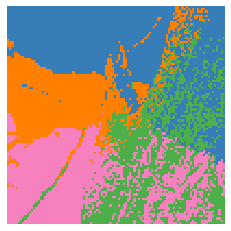

error = 771
Iteration = 4
Current mean:
[[-0.5  -0.44  0.03 -0.06]
 [ 0.19  0.1  -0.41  0.63]
 [ 0.63 -0.13 -0.09 -0.4 ]
 [-0.15  0.61  0.37 -0.02]]


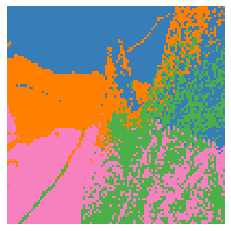

error = 708
Iteration = 5
Current mean:
[[-0.59 -0.43 -0.03 -0.14]
 [ 0.2   0.01 -0.33  0.64]
 [ 0.63 -0.12 -0.08 -0.4 ]
 [-0.15  0.59  0.38 -0.  ]]


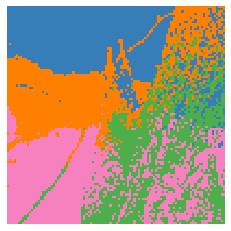

error = 539
Iteration = 6
Current mean:
[[-0.65 -0.43 -0.09 -0.21]
 [ 0.21 -0.05 -0.27  0.64]
 [ 0.63 -0.1  -0.08 -0.43]
 [-0.15  0.57  0.39  0.01]]


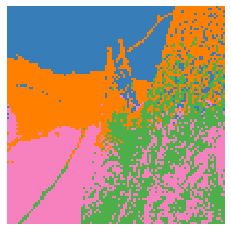

error = 379
Iteration = 7
Current mean:
[[-0.67 -0.42 -0.13 -0.24]
 [ 0.22 -0.08 -0.23  0.63]
 [ 0.63 -0.09 -0.09 -0.45]
 [-0.15  0.56  0.38  0.01]]


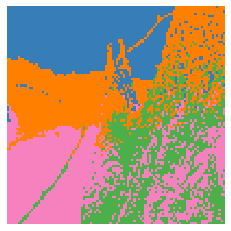

error = 216
Iteration = 8
Current mean:
[[-0.68 -0.42 -0.14 -0.24]
 [ 0.22 -0.11 -0.21  0.62]
 [ 0.63 -0.07 -0.09 -0.47]
 [-0.15  0.56  0.38  0.02]]


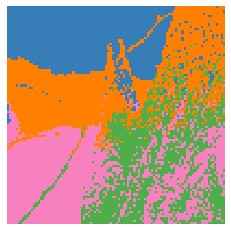

error = 103
Iteration = 9
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.23 -0.12 -0.21  0.61]
 [ 0.63 -0.06 -0.09 -0.48]
 [-0.16  0.56  0.38  0.02]]


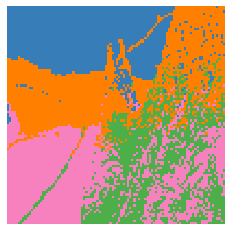

error = 51
Iteration = 10
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.23 -0.12 -0.21  0.61]
 [ 0.63 -0.05 -0.09 -0.48]
 [-0.16  0.57  0.38  0.02]]


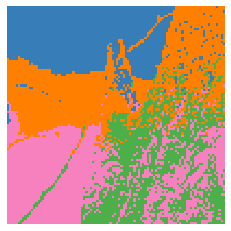

error = 35
Iteration = 11
Current mean:
[[-0.68 -0.42 -0.15 -0.25]
 [ 0.23 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.09 -0.49]
 [-0.16  0.57  0.37  0.02]]


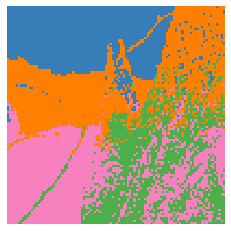

error = 13
Iteration = 12
Current mean:
[[-0.68 -0.42 -0.15 -0.25]
 [ 0.23 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


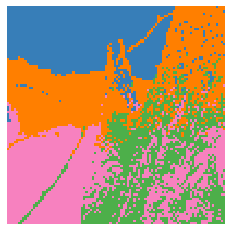

error = 9
Iteration = 13
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


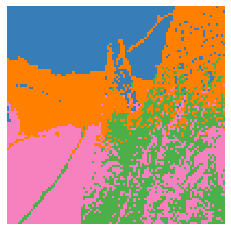

error = 5
Iteration = 14
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


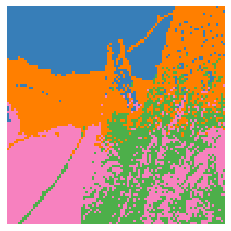

error = 0
Iteration = 15
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


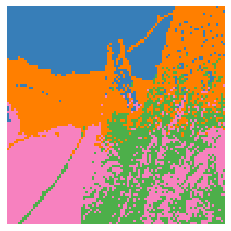

error = 0
Iteration = 16
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


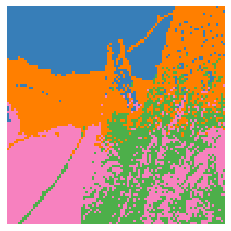

error = 0
Iteration = 17
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


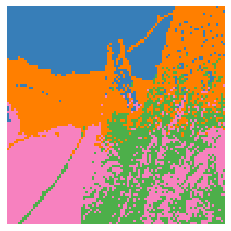

error = 0
Iteration = 18
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


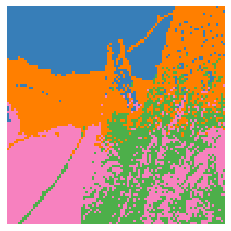

error = 0
Iteration = 19
Current mean:
[[-0.68 -0.42 -0.14 -0.25]
 [ 0.24 -0.12 -0.2   0.61]
 [ 0.63 -0.05 -0.08 -0.49]
 [-0.16  0.57  0.37  0.02]]


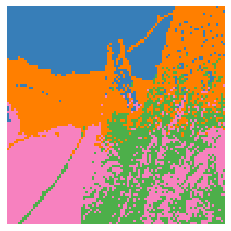

error = 0


In [14]:
k = 4
U_norm = choose_eigenvector(np.real(eigenvalue_norm), np.real(eigenvector_norm), k)
T = np.zeros_like(U)
T = U_norm / (np.sum(U_norm**2, axis=1)**0.5).reshape(-1,1)
new_classification = k_means(T, k, initial='kmean++', file_name='rabbit')

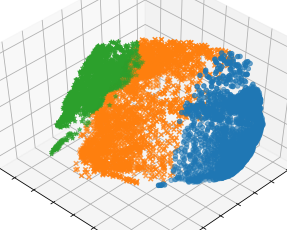

In [15]:
plot_eigenvector(U_norm[:,0], U_norm[:,1], U_norm[:,2], new_classification)

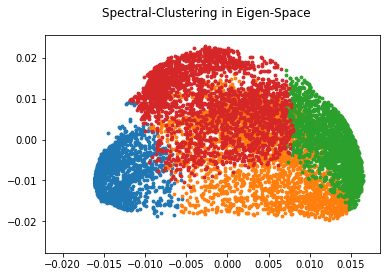

In [16]:
draw_eigenspace(new_classification, U_norm, k)

In [17]:
# import imageio as io
# import os



# file_names = sorted((fn for fn in os.listdir('.') if fn.startswith('rabbit_')))

# #making animation
# with io.get_writer('coast_4.gif', mode='I', duration=0.5) as writer:
#     for filename in file_names:
#         print(filename)
#         image = io.imread(filename)
#         writer.append_data(image)
# writer.close()

In [18]:
# def merge_gifs(gifs):
#     #Create reader object for the gif
#     gif = []
#     file_names = sorted((fn for fn in os.listdir('./normal')))
#     for filename in file_names:
#         print(filename)
#         gif.append(imageio.get_reader('./normal/'+filename))

#     #Create writer object
#     new_gif = imageio.get_writer('./normal'+'.gif', mode='I', fps=2)

#     for frame_number in range(20):
#         img = []
#         for i in range(len(gif)):
#             img.append(gif[i].get_next_data())
#         #here is the magic
#         new_image = np.hstack(img)
#         new_gif.append_data(new_image)
#     for i in range(len(gif)):
#         gif[i].close()
#     new_gif.close()
    
# merge_gifs('output4')